# Chaohu result plot


Test operational & counted reward function 

In [1]:
import os,yaml
import pandas as pd
import numpy as np
from swmm_api import read_inp_file
from envs.chaohu import chaohu
from utils.config import Arguments
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rc('font',family = 'Times New Roman')
colors = {'IQL':'#1f77b4','VDN':'#2ca02c', 'DQN':'#ff7f0e','HC':'#d62728'}

HERE = os.getcwd()

c:\Users\MOMO\.conda\envs\storm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plot training rewards

In [7]:
hyps = yaml.load(open(os.path.join(HERE,'utils','config.yaml'), "r"), yaml.FullLoader)['chaohu']
hyp_test = hyps['test']
cwd = os.path.join(HERE,hyp_test['cwd'])
agents = hyp_test['test_agents']
records = {'eval_perfs':{},'train_rewards':{}}
for agent in agents:
    model_dir = os.path.join(HERE,hyps[agent]['cwd'])
    if 'eval_perfs.npy' not in os.listdir(model_dir):
        model_dir = os.path.join(model_dir,'..')
    for item in records:
        records[item][agent] = np.load(os.path.join(model_dir,'%s.npy'%item))


### Plot training rewards

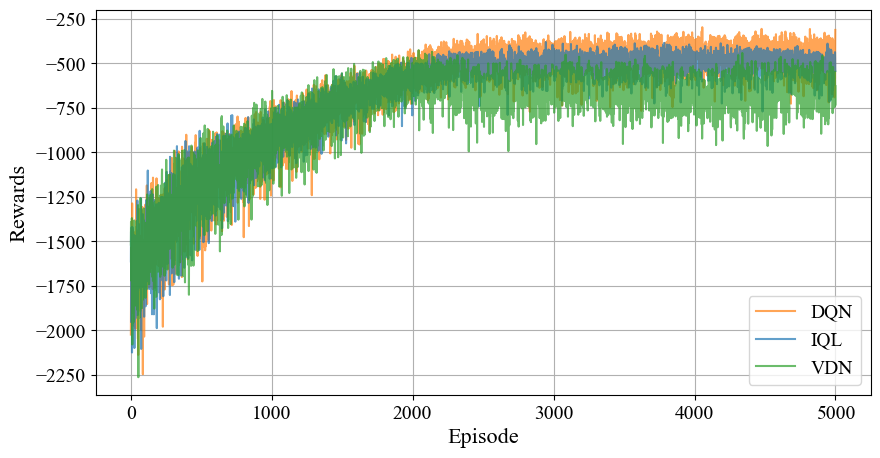

In [3]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize = (10,5))
lines = []
for agent,record in records['train_rewards'].items():
    rewards = ax.plot(np.arange(len(record)),record.sum(axis=1),color = colors[agent],label=agent,alpha=0.7)
    lines += rewards
    ax.set_xlabel('Episode',fontsize=16)
    ax.set_ylabel('Rewards',fontsize=16)
    ax.tick_params(labelsize=14)
    ax.grid(True)
ax.legend(lines,[f.get_label() for f in lines],loc='lower right',fontsize=14)
fig.savefig(os.path.join(cwd,'train_rewards.png'),dpi=600)

### Plot evaluation performance

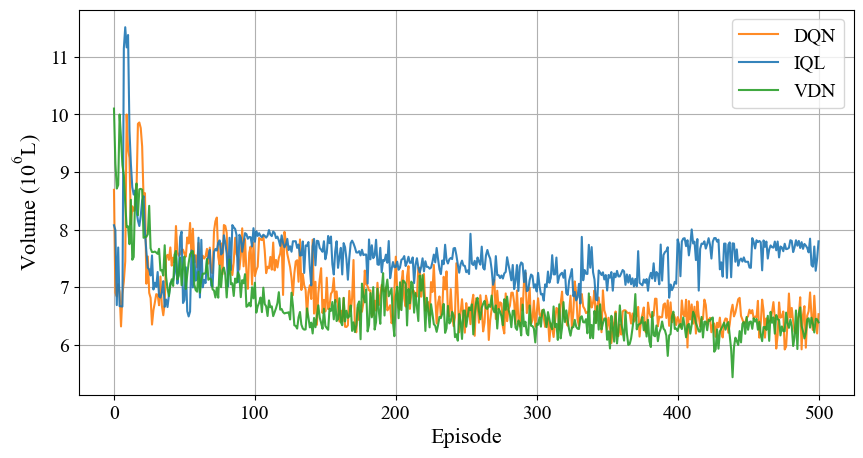

In [4]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize = (10,5))
lines = []
for agent,record in records['eval_perfs'].items():
    perfs = ax.plot(np.arange(len(record)),record.sum(axis=1)/2e3,color = colors[agent],label=agent,alpha=0.9)
    lines += perfs
    ax.set_xlabel('Episode',fontsize=16)
    ax.set_ylabel('Volume ($\mathregular{10^6 L}$)',fontsize=16)
    ax.tick_params(labelsize=14)
    ax.grid(True)
ax.legend(lines,[f.get_label() for f in lines],loc='upper right',fontsize=14)
fig.savefig(os.path.join(cwd,'eval_perfs.png'),dpi=600)

### Plot rewards with performance together

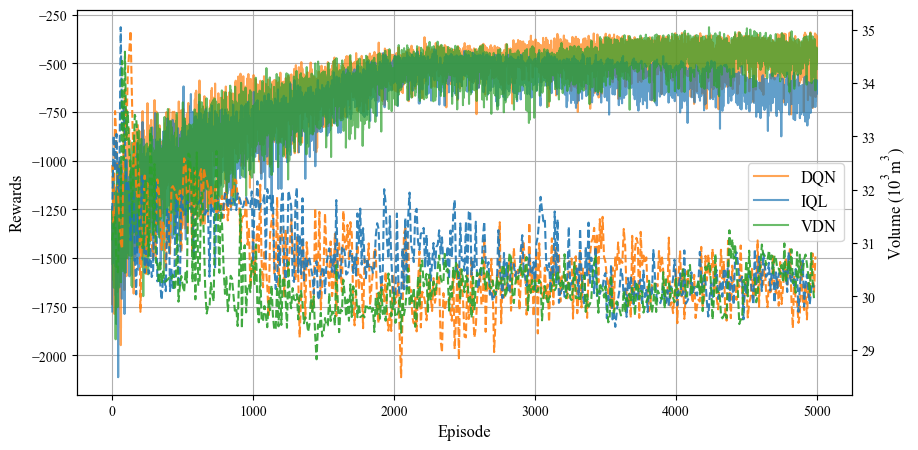

In [8]:
fig,ax = plt.subplots(nrows=1,ncols=1,figsize = (10,5))
lines = []
for agent,record in records['train_rewards'].items():
    rewards = ax.plot(np.arange(len(record)),record.sum(axis=1),color = colors[agent],label=agent,alpha=0.7)
    lines += rewards
    ax.set_xlabel('Episode',fontsize=12)
    ax.set_ylabel('Rewards',fontsize=12)
ax2 = ax.twinx()
for agent,record in records['eval_perfs'].items():
    perfs = ax2.plot(np.array([i for i in range(0,len(record)*10,10)]),record.sum(axis=1)/2e3,'--',color = colors[agent],label=agent,alpha=0.9)
    ax2.set_ylabel('Volume ($\mathregular{10^3 m^3}$)',fontsize=12)
# ax.tick_params(labelsize=14)
ax.grid(True)
ax.legend(lines,[f.get_label() for f in lines],loc='center right',fontsize=12)
fig.savefig(os.path.join(cwd,'train_test.png'),dpi=600)

## Plot performance (CSO&flooding) result

Test operational & counted reward function 

In [2]:
env = chaohu()
hyps = yaml.load(open(os.path.join(HERE,'utils','config.yaml'), "r"), yaml.FullLoader)[env.config['env_name']]
hyp_test = hyps['test']
args = Arguments(env.get_args(), hyp_test)
logger = args.init_test(load=True)

| Arguments Keep cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu_0
| Arguments Create cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu_0


### Plot four fixed rainfalls

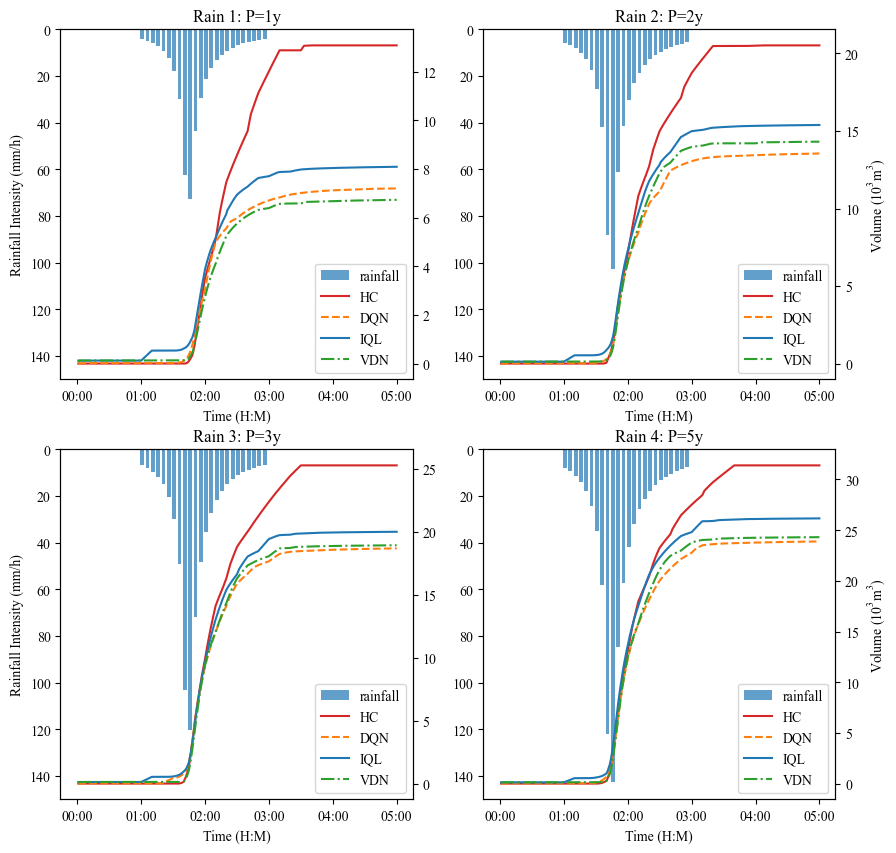

In [10]:
styles = {'IQL':'-','VDN':'-.', 'DQN':'--','HC':'-'}
pump_class = ['CC-S','CC-R','JK-S','JK-R']
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

for i,(event,record) in enumerate(logger.records.items()):
    event = event.replace('_',' ')
    if 'P' in record:
        event += ': P='+record['P']
    targets = {k:pd.read_json(v)[:5*60] for k,v in record['target'].items()}
    ax = eval('ax%s'%(i+1))
    # Plot CSO & flooding
    # for col,ax in zip(['Flooding','CSO'],[axL,axR]):
    rain_index = [time for idx,time in enumerate(targets['HC'].index) if idx%5==0]
    rain = ax.bar(rain_index,targets['HC'].loc[rain_index,'Rainfall'],
    label='rainfall',width=0.0025,alpha=0.7,zorder=1)

    axR = ax.twinx()
    ax.invert_yaxis()
    ax.set_ylim(150,0)
    objs = [rain]
    for agent,table in targets.items():
        flood = axR.plot(table.index,table['Flooding']+table['CSO'],styles[agent],color=colors[agent],label=agent)
        objs += flood
    ax.set_xlabel('Time (H:M)')
    axR.set_title(event)
    axR.yaxis.set_ticks_position('right')
    axR.yaxis.set_label_position('right')    
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axR.legend(objs,[l.get_label() for l in objs],loc='lower right')
    if i in [1,3]:
        axR.set_ylabel('Volume ($\mathregular{10^3 m^3}$)')
    if i in [0,2]:
        ax.set_ylabel('Rainfall Intensity (mm/h)')
    # fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=5,frameon=False)
fig.savefig(os.path.join(args.cwd,'total_perf'))


### Plot 100 rainfalls (no output in ipynb)

In [6]:
logger.load(os.path.join(logger.cwd,'records100.json'))
sum([int(max(pd.read_json(record['target']['HC'])['Rainfall'])>150) for record in logger.records.values()])

24

In [7]:
styles = {'IQL':'-','VDN':'-.', 'DQN':'--','HC':'-'}
pump_class = ['CC-S','CC-R','JK-S','JK-R']
logger.load(os.path.join(logger.cwd,'records100.json'))

for i,(event,record) in enumerate(logger.records.items()):
    event = event.replace('_',' ')
    if 'P' in record:
        event += ': P='+record['P']
    if i%4 == 0:
        fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

    targets = {k:pd.read_json(v)[:5*60] for k,v in record['target'].items()}
    ax = eval('ax%s'%(i%4+1))
    # Plot CSO & flooding
    # for col,ax in zip(['Flooding','CSO'],[axL,axR]):
    rain_index = [time for idx,time in enumerate(targets['HC'].index) if idx%5==0]
    rain = ax.bar(rain_index,targets['HC'].loc[rain_index,'Rainfall'],
    label='rainfall',width=0.0025,alpha=0.7,zorder=1)

    axR = ax.twinx()
    ax.invert_yaxis()
    ax.set_ylim(150,0)
    objs = [rain]
    for agent,table in targets.items():
        flood = axR.plot(table.index,table['Flooding']+table['CSO'],styles[agent],color=colors[agent],label=agent)
        objs += flood
    ax.set_xlabel('Time (H:M)')
    axR.set_title(event)
    axR.yaxis.set_ticks_position('right')
    axR.yaxis.set_label_position('right')    
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axR.legend(objs,[l.get_label() for l in objs],loc='lower right')
    if i%4 in [1,3]:
        axR.set_ylabel('Volume ($\mathregular{10^3 m^3}$)')
    if i%4 in [0,2]:
        ax.set_ylabel('Rainfall Intensity (mm/h)')
    # fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=5,frameon=False)
    if i%4 == 3: 
        fig.savefig(os.path.join(args.cwd,'total_perf_%s'%(i//4)))
    plt.close()

### Plot CSO & flooding separately

Finish plot: perf_Rain 1
Finish plot: perf_Rain 2
Finish plot: perf_Rain 3
Finish plot: perf_Rain 4


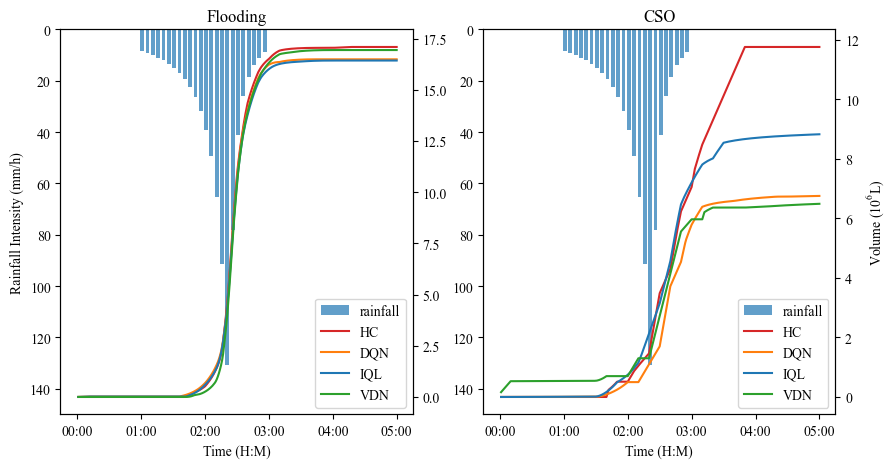

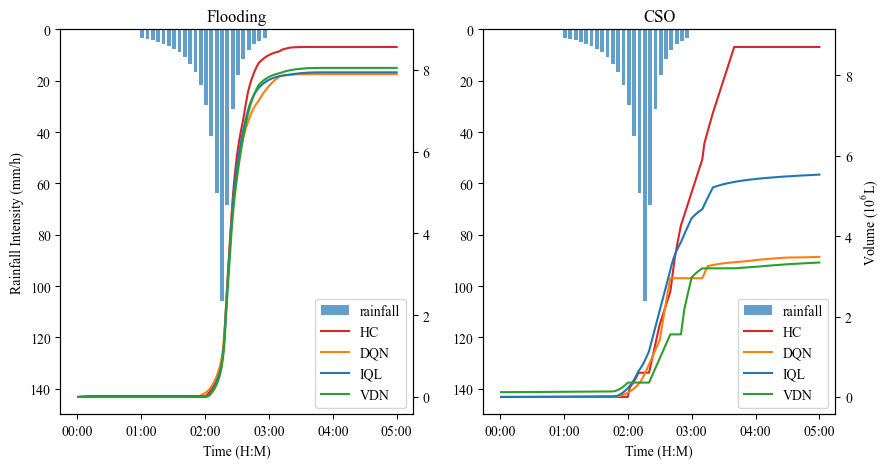

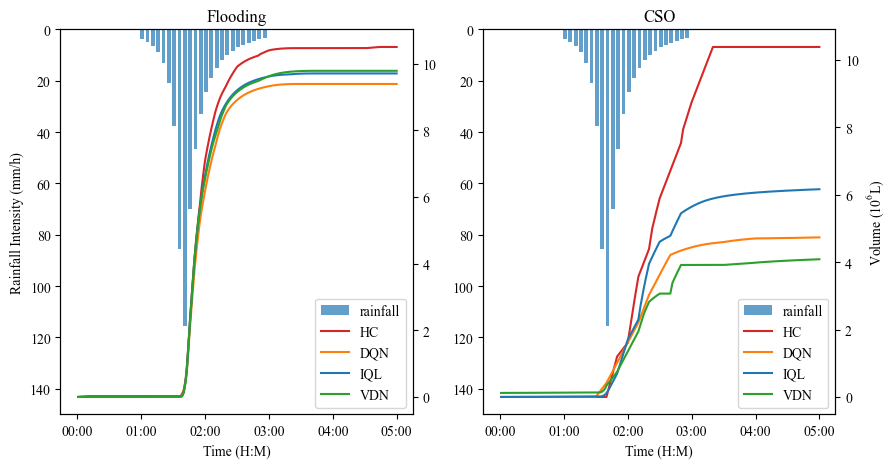

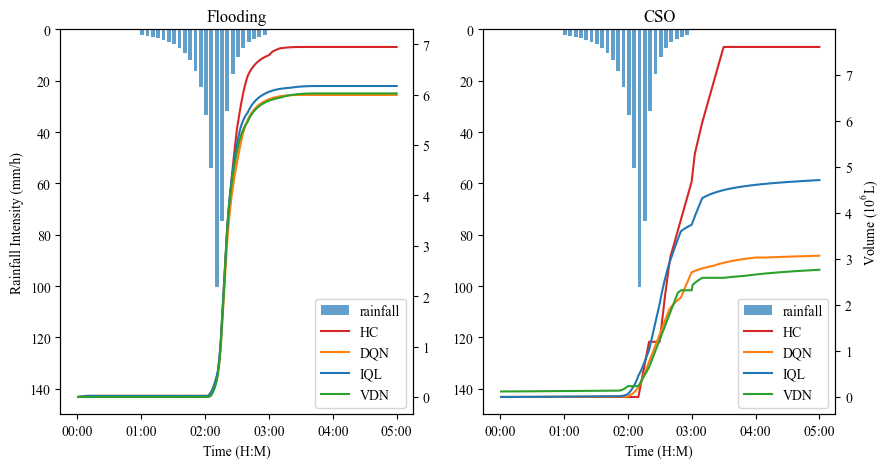

In [8]:

pump_class = ['CC-S','CC-R','JK-S','JK-R']

for event,record in logger.records.items():
    targets = {k:pd.read_json(v)[:5*60] for k,v in record['target'].items()}

    # Plot CSO & flooding
    fig,(axL,axR) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
    for col,ax in zip(['Flooding','CSO'],[axL,axR]):
        rain_index = [time for idx,time in enumerate(targets['HC'].index) if idx%5==0]
        rain = ax.bar(rain_index,targets['HC'].loc[rain_index,'Rainfall'],
        label='rainfall',width=0.0025,alpha=0.7,zorder=1)

        ax2 = ax.twinx()
        ax.invert_yaxis()
        ax.set_ylim(150,0)
        objs = [rain]
        for agent,table in targets.items():
            flood = ax2.plot(table.index,table[col],color=colors[agent],label=agent)
            objs += flood
        ax.set_xlabel('Time (H:M)')
        ax2.set_title(col)
        ax2.yaxis.set_ticks_position('right')
        ax2.yaxis.set_label_position('right')    
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        ax2.legend(objs,[l.get_label() for l in objs],loc='lower right')
    ax2.set_ylabel('Volume ($\mathregular{10^6 L}$)')
    axL.set_ylabel('Rainfall Intensity (mm/h)')
    # fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=5,frameon=False)
    fig.savefig(os.path.join(args.cwd,'perf_%s'%event))
    print("Finish plot: perf_%s"%event)

## Summarize the control performance

Test operational & counted reward function 

In [2]:
env = chaohu()
hyps = yaml.load(open(os.path.join(HERE,'utils','config.yaml'), "r"), yaml.FullLoader)[env.config['env_name']]
hyp_test = hyps['test']
args = Arguments(env.get_args(), hyp_test)
logger = args.init_test(load=True)

| Arguments Keep cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu_0
| Arguments Create cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu_0


### summarize 4 rainfalls

In [16]:
columns = []
# for col in ['Flooding and CSO volume','Pumping energy']:
for col in ['System flooding','CSO','Pumping energy']:
    columns += [(col,agent) for agent in ['HC']+hyp_test['test_agents']]
columns = pd.MultiIndex.from_tuples(columns)
results = pd.DataFrame(columns=columns)
for event,record in logger.records.items():
    perf = {(k,key):v for key,value in record['performance'].items() for k,v in value.items()}
    # for agent in ['HC']+hyp_test['test_agents']:
    #     perf['Flooding and CSO volume',agent] = perf['System flooding',agent] + perf['CSO',agent]
    results.loc[event] = perf

logger.load(os.path.join(logger.cwd,'records100.json'))
perfs = {k:0 for k in results.columns}
for event,record in logger.records.items():
    perf = {(k,key):perf[k,key]+v for key,value in record['performance'].items() for k,v in value.items()}
# for agent in ['HC']+hyp_test['test_agents']:
#     perf['Flooding and CSO volume',agent] = perf['System flooding',agent] + perf['CSO',agent]
results.loc['Total of 100 rainfall events'] = perf
results.round(3).to_clipboard()

System flooding                                \
                                          HC       DQN       IQL       VDN   
Rain 1                                 5.017     4.677     3.817     3.785   
Rain 2                                10.394     9.388     8.375     8.951   
Rain 3                                14.218    12.251    11.721    12.489   
Rain 4                                18.516    18.108    16.459    16.895   
Total of 100 rainfall events        1557.762  1483.532  1375.763  1441.687   

                                   CSO                             \
                                    HC      DQN      IQL      VDN   
Rain 1                           8.143    2.032    4.072    3.857   
Rain 2                          10.154    5.186    6.906    5.841   
Rain 3                          11.017    7.710    8.078    7.247   
Rain 4                          12.976    6.537    9.145    8.955   
Total of 100 rainfall events  1056.340  554.654  720.198  649.181   

                             Pumping energy                              
                                         HC      DQN       IQL      VDN  
Rain 1                               143.61    34.06     45.75    36.40  
Rain 2                               181.21    78.30     94.59    85.38  
Rain 3                               205.41    99.17    117.80   104.92  
Rain 4                               227.01   114.05    143.39   123.69  
Total of 100 rainfall events       18995.39  8847.63  10069.80  9918.62

### summarize 100 rainfalls

In [8]:
columns = []
# for col in ['Flooding and CSO volume','Pumping energy']:
for col in ['System flooding','CSO','Pumping energy']:
    columns += [(col,agent) for agent in ['HC']+hyp_test['test_agents']]
columns = pd.MultiIndex.from_tuples(columns)
results = pd.DataFrame(columns=columns)

logger.load(os.path.join(logger.cwd,'records100.json'))
for event,record in logger.records.items():
    perf = {(k,key):v for key,value in record['performance'].items() for k,v in value.items()}
    # for agent in ['HC']+hyp_test['test_agents']:
    #     perf['Flooding and CSO volume',agent] = perf['System flooding',agent] + perf['CSO',agent]
    results.loc[event] = perf

perfs = {k:0 for k in results.columns}
for event,record in logger.records.items():
    perf = {(k,key):perf[k,key]+v for key,value in record['performance'].items() for k,v in value.items()}
# for agent in ['HC']+hyp_test['test_agents']:
#     perf['Flooding and CSO volume',agent] = perf['System flooding',agent] + perf['CSO',agent]
results.loc['Total of 100 rainfall events'] = perf
results.round(3).to_csv(os.path.join(args.cwd,'results100.csv'))
results

System flooding                                \
                                          HC       DQN       IQL       VDN   
Rain_1                                 6.023     4.949     5.114     5.390   
Rain_2                                 3.344     2.583     2.683     2.680   
Rain_3                                23.873    22.469    22.015    22.574   
Rain_4                                20.614    18.660    18.465    19.360   
Rain_5                                43.565    41.501    41.641    41.454   
...                                      ...       ...       ...       ...   
Rain_97                               10.700     9.043     9.197     9.296   
Rain_98                               13.238    11.327    11.615    11.607   
Rain_99                               26.227    24.554    24.733    24.786   
Rain_100                              10.754     9.126     9.809     9.700   
Total of 100 rainfall events        1357.438  1220.925  1238.349  1250.731   

                                  CSO                             \
                                   HC      DQN      IQL      VDN   
Rain_1                          7.396    2.759    4.254    2.460   
Rain_2                          5.587    2.264    2.693    1.938   
Rain_3                         14.198    7.996   10.198    8.476   
Rain_4                         12.114    6.797    8.966    7.265   
Rain_5                         16.477   13.625   13.173   12.210   
...                               ...      ...      ...      ...   
Rain_97                         9.318    4.101    5.394    4.493   
Rain_98                         8.780    4.020    5.383    4.524   
Rain_99                        13.784    8.922    9.504    8.514   
Rain_100                        9.420    3.699    5.369    3.950   
Total of 100 rainfall events  976.487  514.575  634.986  503.050   

                             Pumping energy                               
                                         HC       DQN       IQL      VDN  
Rain_1                               135.43     68.38     60.77    46.17  
Rain_2                               106.24     72.34     48.64    44.77  
Rain_3                               254.65    163.16    165.14   147.17  
Rain_4                               218.30    133.82    144.74   121.54  
Rain_5                               295.72    219.14    218.68   230.85  
...                                     ...       ...       ...      ...  
Rain_97                              178.49    103.33     93.03    81.93  
Rain_98                              176.07    103.11     95.60    85.87  
Rain_99                              243.74    183.09    167.78   157.60  
Rain_100                             173.90     72.47    111.40    93.97  
Total of 100 rainfall events       17775.68  10783.09  10554.27  9684.48  

[101 rows x 12 columns]

## Plot operation result

In [10]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits.axisartist import Axes
import matplotlib.pyplot as plt


In [3]:
env = chaohu()
hyps = yaml.load(open(os.path.join(HERE,'utils','config.yaml'), "r"), yaml.FullLoader)[env.config['env_name']]
hyp_test = hyps['test']
args = Arguments(env.get_args(), hyp_test)
logger = args.init_test(load=True)

| Arguments Keep cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu_0
| Arguments Create cwd: c:\Users\MOMO\Desktop\Pump-RTC\storm\results\chaohu_0


Finish plot: depth_setting_Rain_1
Finish plot: depth_setting_Rain_2
Finish plot: depth_setting_Rain_3
Finish plot: depth_setting_Rain_4


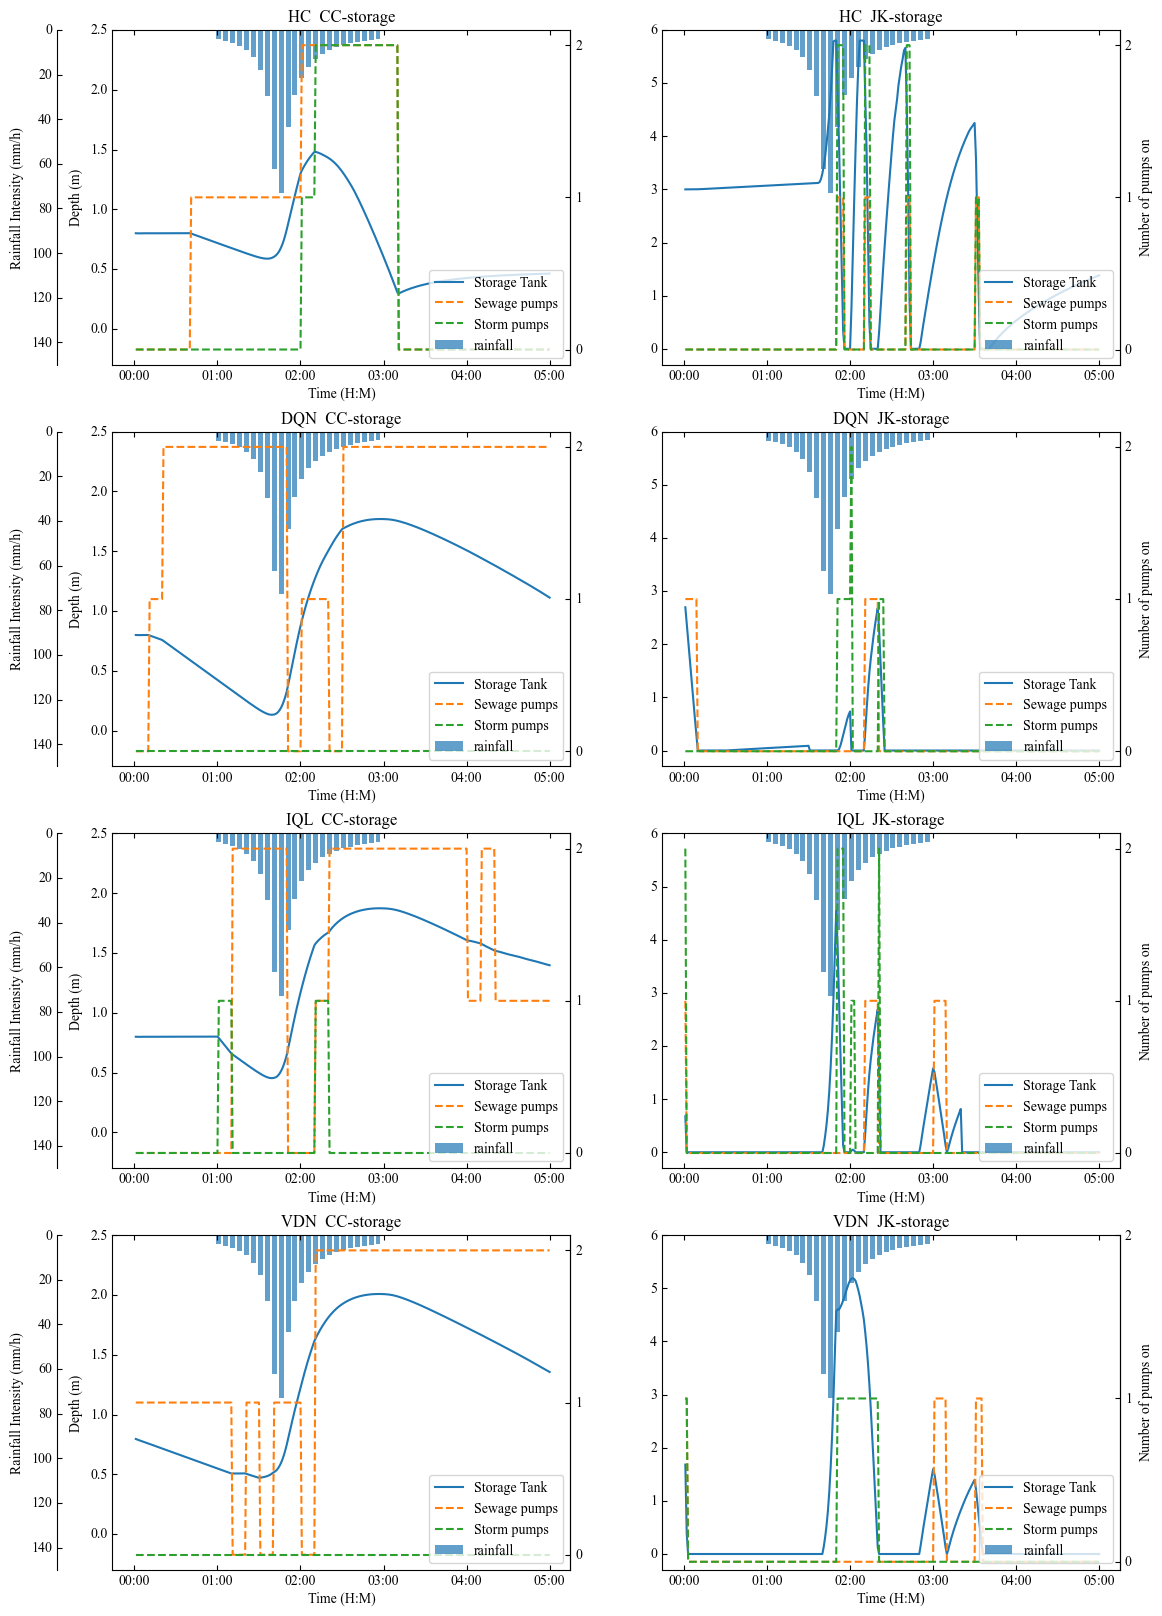

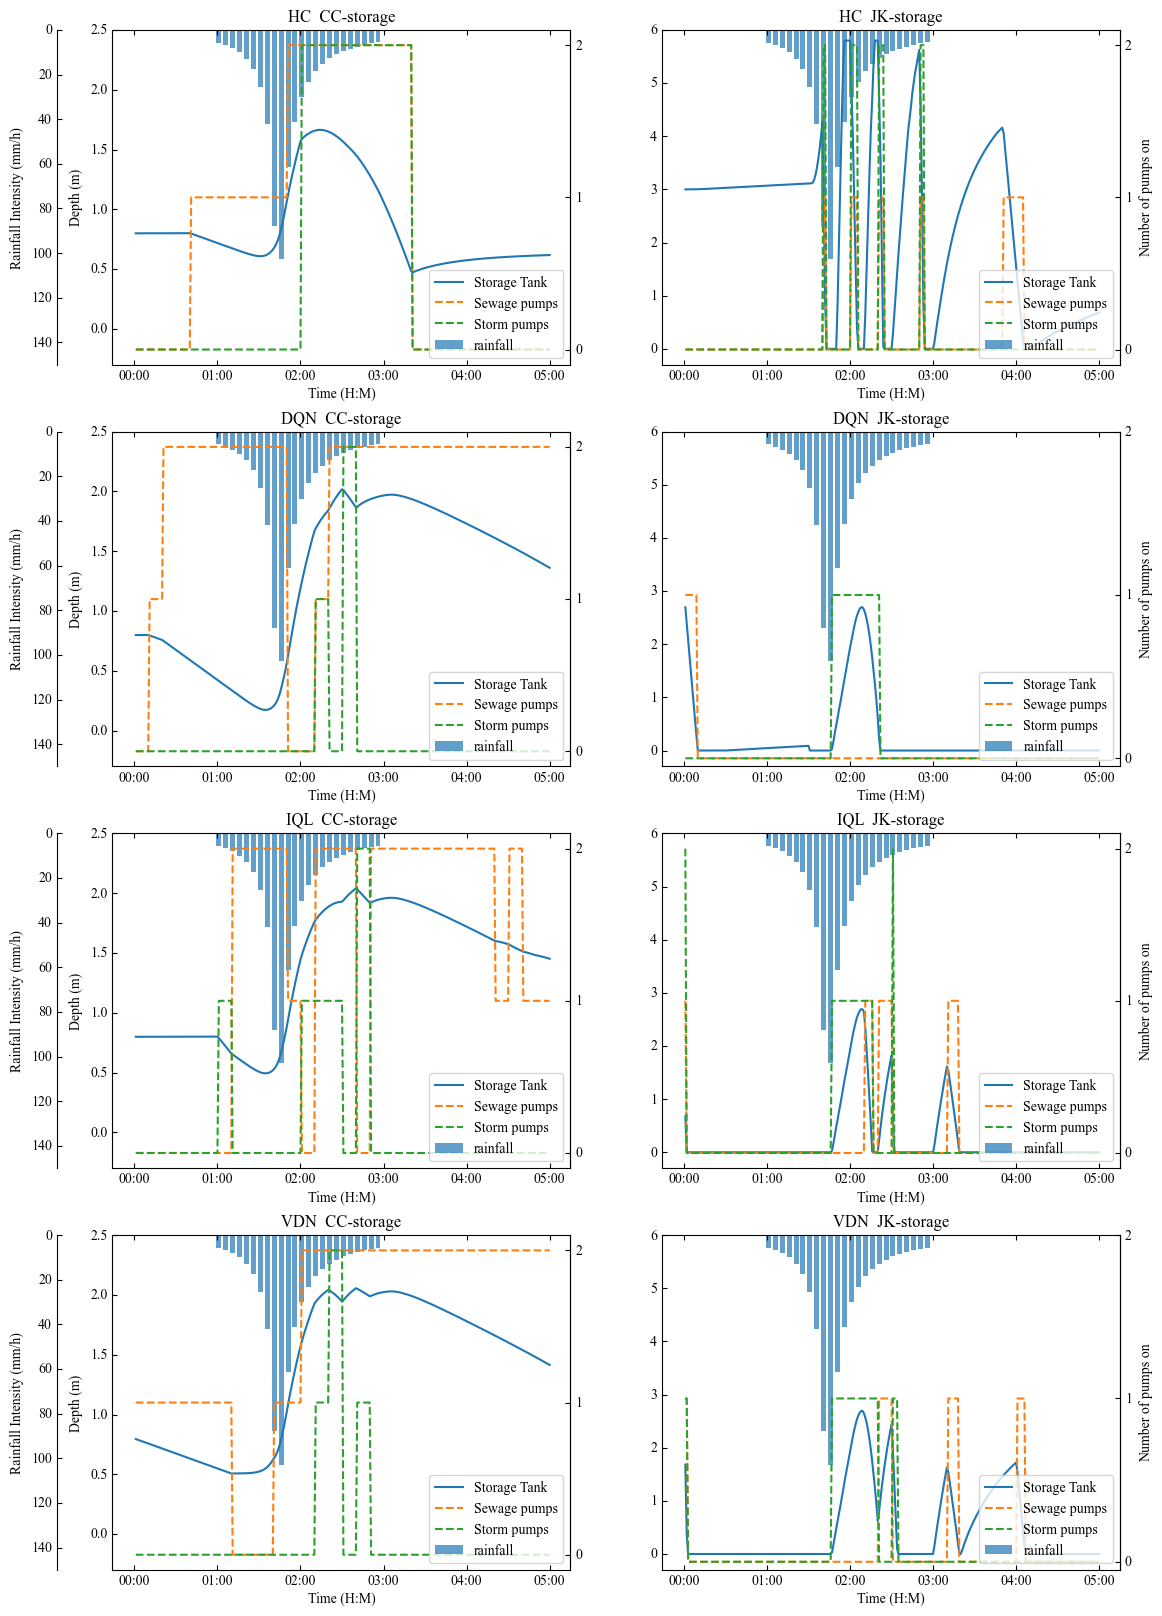

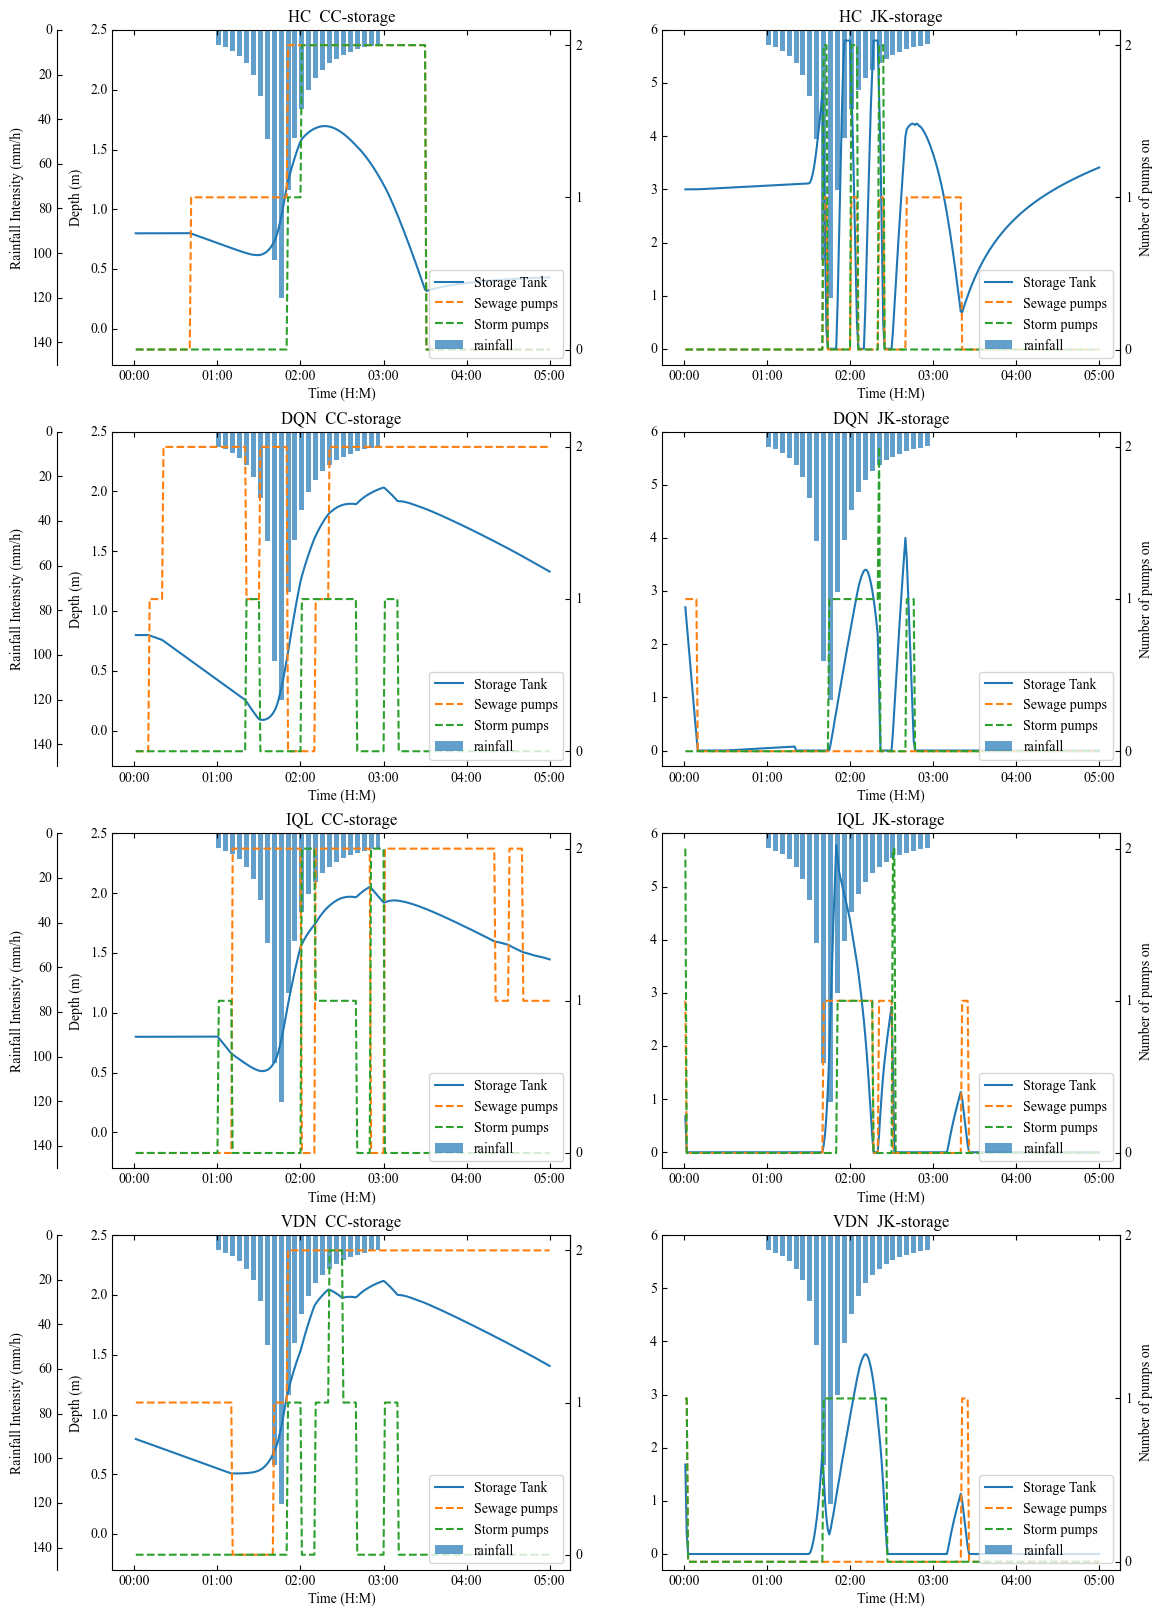

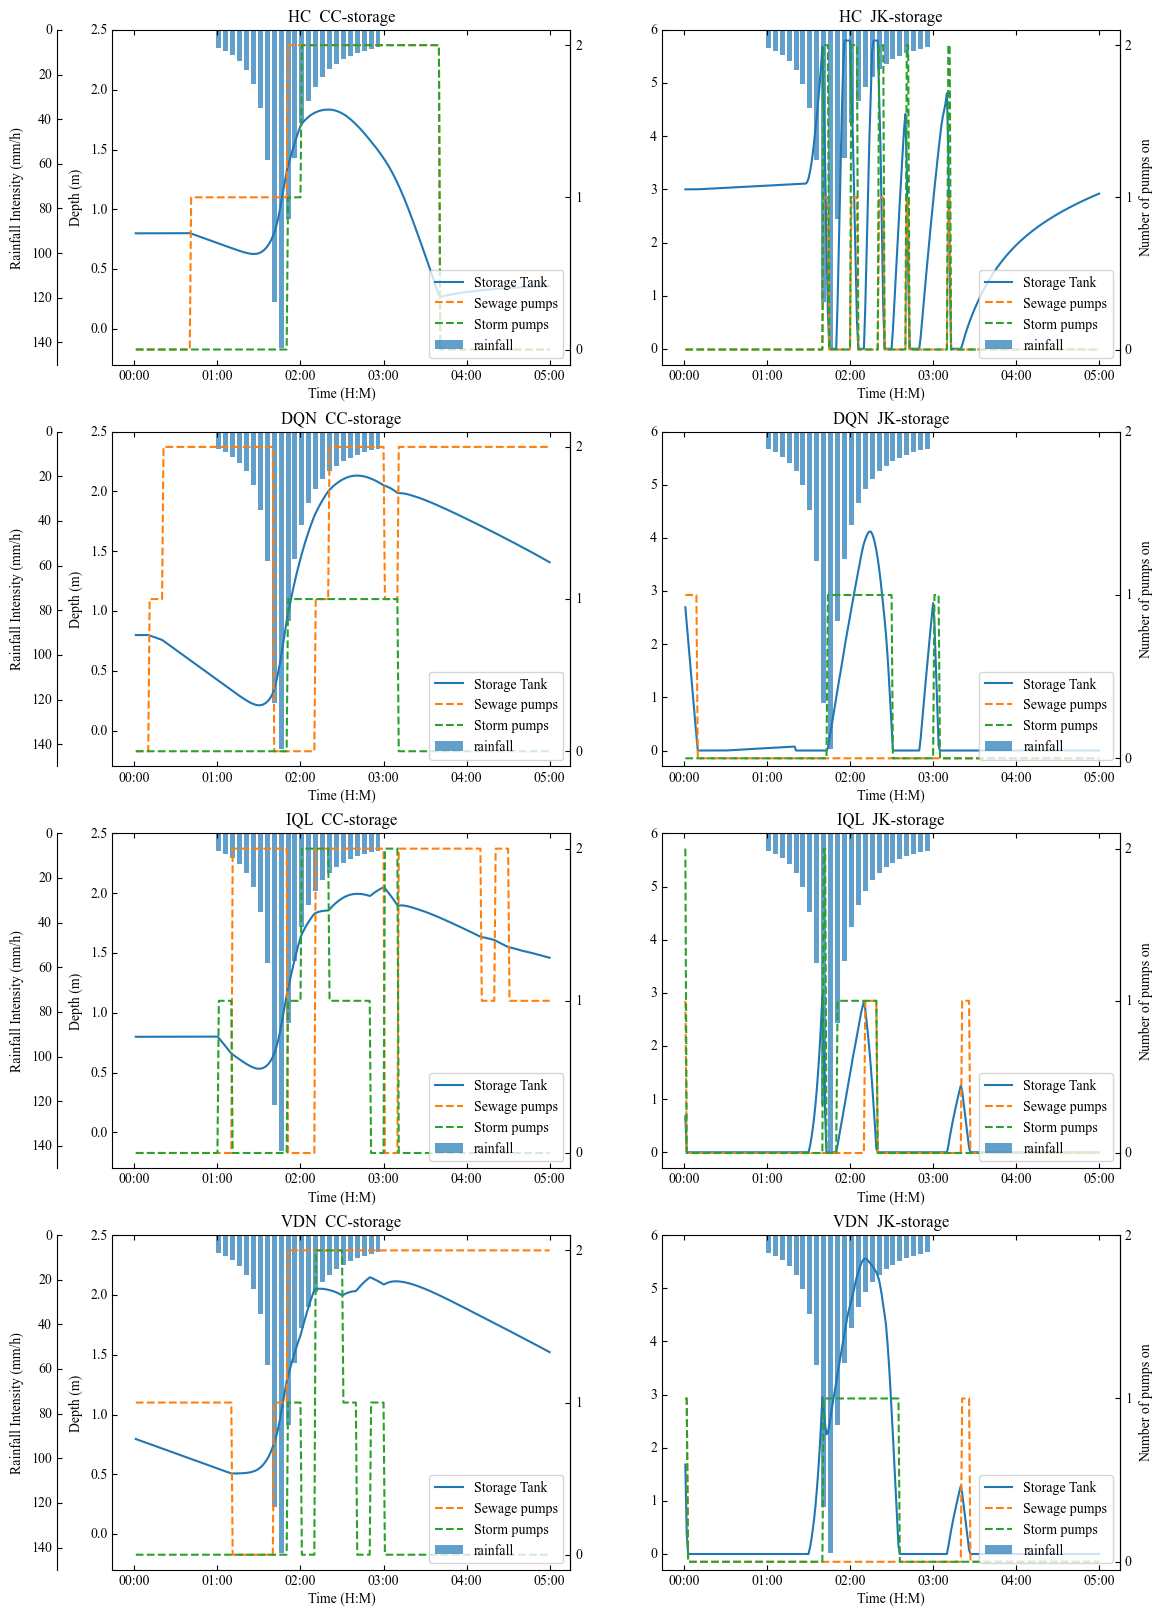

In [36]:
pump_class = ['CC-S','CC-R','JK-S','JK-R']
for event,record in logger.records.items():
    operats = {k:pd.read_json(v)[:5*60] for k,v in record['operation'].items()}
    targets = {k:pd.read_json(v)[:5*60] for k,v in record['target'].items()}

    # Plot the opertion details in CC & JK
    fig = plt.figure(figsize=(13,5*len(operats)))
    for idx,(agent,operat) in enumerate(operats.items()):

        for pump in pump_class:
            operat[pump] = operat.apply(lambda row:sum([row[col]
            for col in operat.columns if col.startswith(pump)]),axis=1).astype(int)
            operat[pump] = operat.apply(lambda row: 0 if row[pump[:3]+'storage']==0 else row[pump],axis=1)
        operat = operat[args.storage + pump_class]

        # rain = axL.bar(operat.index,operat['rainfall'],label='rainfall',width=0.003,alpha=0.6,zorder=1)
        # axL.set_ylabel('Rainfall Intensity (mm/h)')
        for i,col in enumerate(['CC','JK']):
            ax = host_subplot(len(operats),2,idx*2+i+1,figure=fig, axes_class=Axes)
            ax2 = ax.twinx()
            ax3 = ax.twinx()
            ax2.axis['right'].toggle(all=True)
            if col == 'CC':
                ax3.axis["left"] = ax3.new_fixed_axis(loc="left", offset=(-40, 0))
                ax3.axis["right"].toggle(all=False)

            depth = ax.plot(operat.index,operat[col+'-storage'],label='Storage Tank')
            ns = ax2.plot(operat.index,operat[col+'-S'],'--',label='Sewage pumps')
            nr = ax2.plot(operat.index,operat[col+'-R'],'--',label='Storm pumps')

            rain_index = [time for idx,time in enumerate(targets['HC'].index) if idx%5==0]
            rain = ax3.bar(rain_index,targets['HC'].loc[rain_index,'Rainfall'],
            label='rainfall',width=0.0025,alpha=0.7,zorder=1)
            objs = depth+ns+nr+[rain]

            ax3.invert_yaxis()
            ax3.set_ylim(150,0)
            ax.set_xlabel('Time (H:M)')

            ax2.yaxis.set_ticks_position('right')
            ax2.yaxis.set_label_position('right') 
            ax2.set_yticks([0,1,2])

            ax.legend(objs,[l.get_label() for l in objs],loc='lower right')
            ax.set_title(agent + '  '+ col+'-storage')


            ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            ax.set_ylim(-0.3,env.node_properties[col+'-storage']['fullDepth']+0.2)
            
            if col == 'CC':
                ax.set_ylabel('Depth (m)')
                ax3.set_ylabel('Rainfall Intensity (mm/h)')

            else:
                ax3.set_yticks([])
                ax2.set_ylabel('Number of pumps on')
    # fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=3,frameon=False)
    fig.savefig(os.path.join(args.cwd,'depth_setting_%s'%event))
    print("Finish plot: depth_setting_%s"%event)

Finish plot: depth_setting_Rain_1
Finish plot: depth_setting_Rain_2
Finish plot: depth_setting_Rain_3
Finish plot: depth_setting_Rain_4


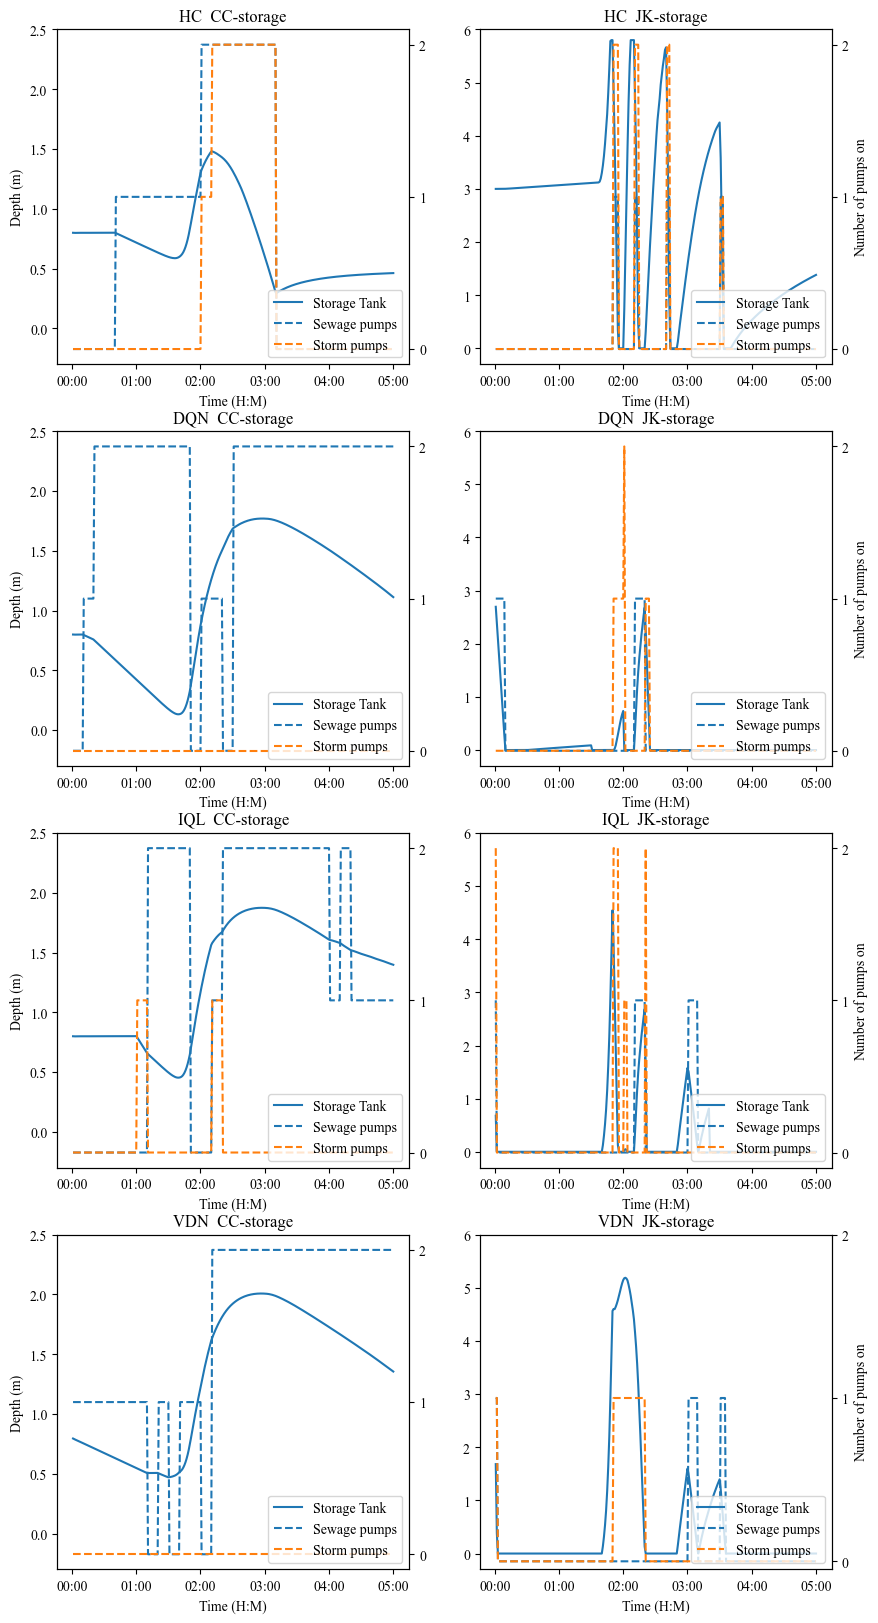

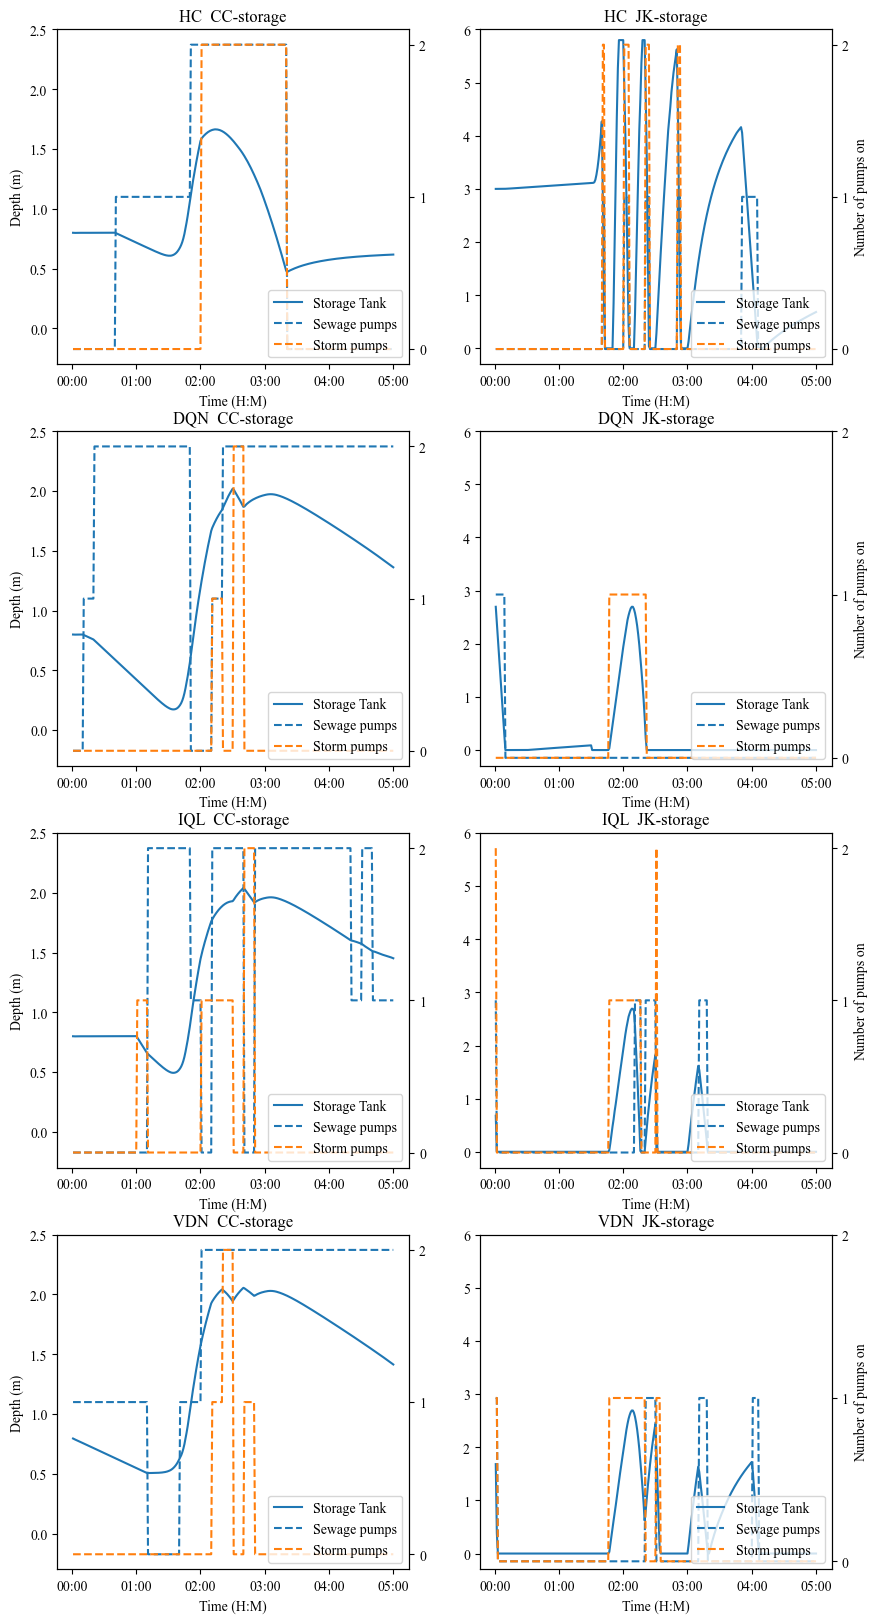

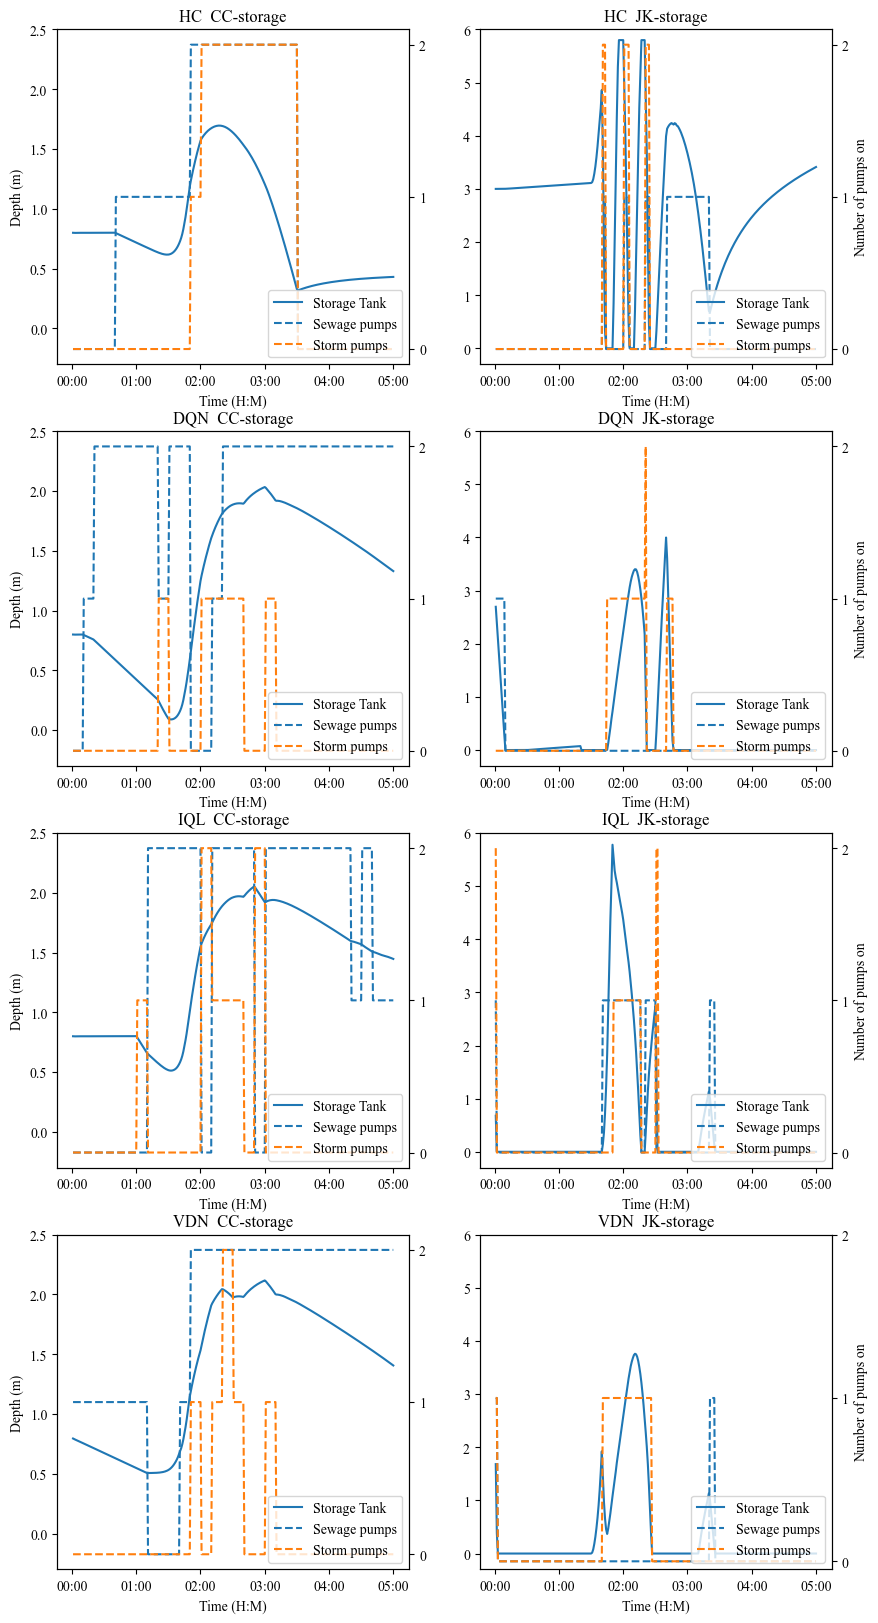

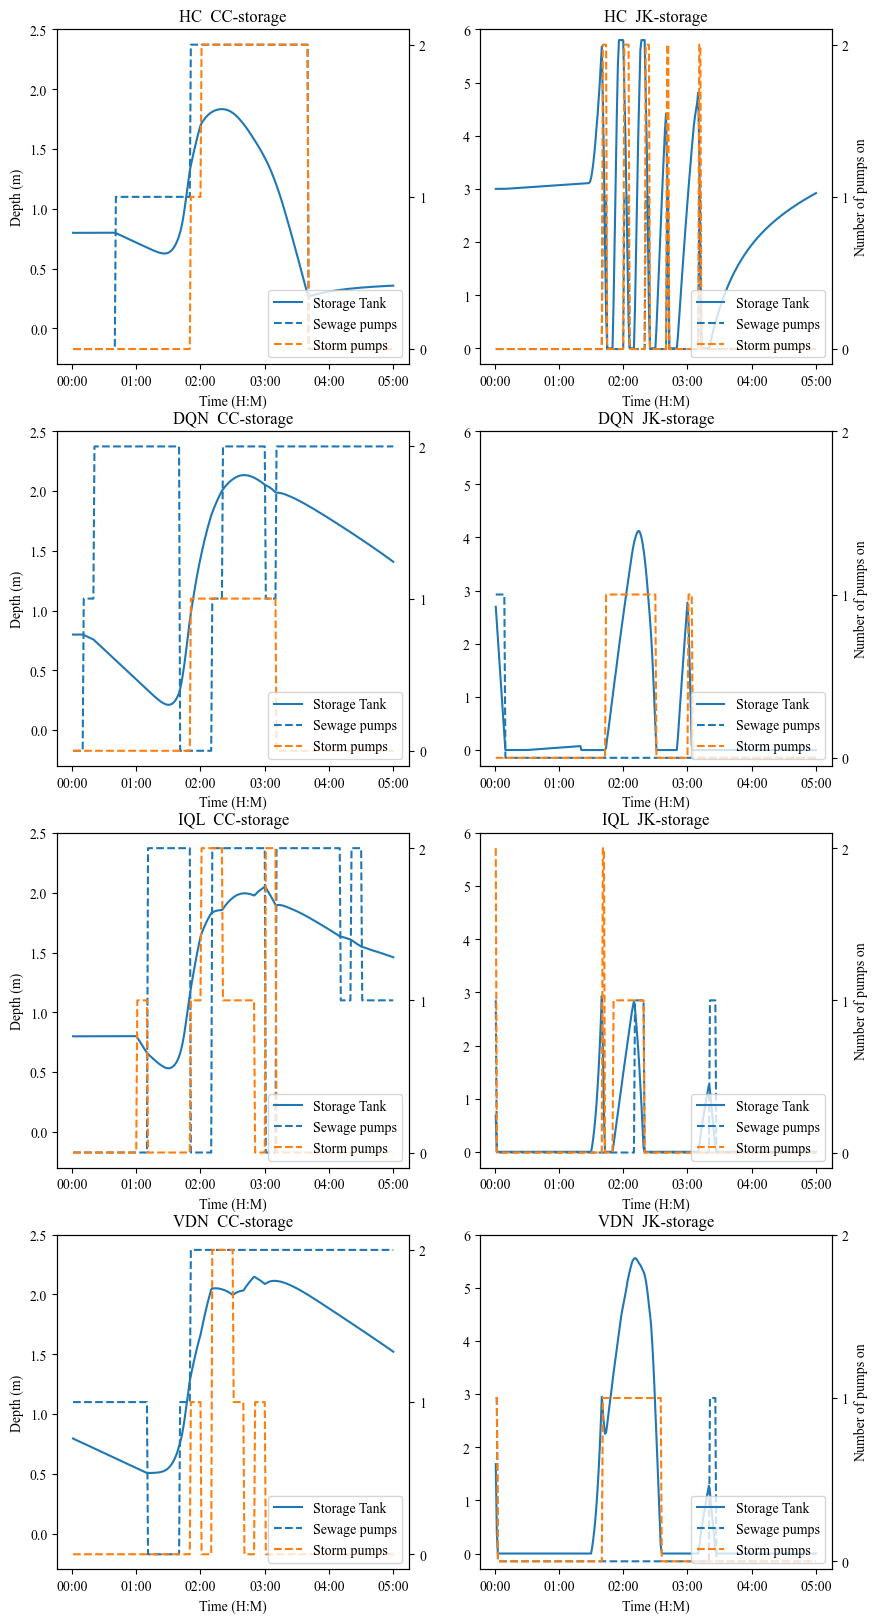

In [4]:
pump_class = ['CC-S','CC-R','JK-S','JK-R']
for event,record in logger.records.items():
    operats = {k:pd.read_json(v)[:5*60] for k,v in record['operation'].items()}
    # Plot the opertion details in CC & JK
    fig,axes = plt.subplots(nrows=len(operats),ncols=2,figsize=(10,5*len(operats)))
    axes = np.array([axes]) if len(axes.shape) == 1 else axes
    for (agent,operat),(axL,axR) in zip(operats.items(),axes):

        for pump in pump_class:
            operat[pump] = operat.apply(lambda row:sum([row[col]
            for col in operat.columns if col.startswith(pump)]),axis=1).astype(int)
            operat[pump] = operat.apply(lambda row: 0 if row[pump[:3]+'storage']==0 else row[pump],axis=1)
        operat = operat[args.storage + pump_class]

        # rain = axL.bar(operat.index,operat['rainfall'],label='rainfall',width=0.003,alpha=0.6,zorder=1)
        # axL.set_ylabel('Rainfall Intensity (mm/h)')
        for col,ax in zip(['CC','JK'],[axL,axR]):
            depth = ax.plot(operat.index,operat[col+'-storage'],label='Storage Tank')
            ax2 = ax.twinx()
            ns = ax2.plot(operat.index,operat[col+'-S'],'--',label='Sewage pumps')
            nr = ax2.plot(operat.index,operat[col+'-R'],'--',label='Storm pumps')
            objs = depth+ns+nr
            ax.set_xlabel('Time (H:M)')
            ax2.legend(objs,[l.get_label() for l in objs],loc='lower right')
            ax2.set_title(agent + '  '+ col+'-storage')
            ax2.set_yticks([0,1,2])
            ax2.yaxis.set_ticks_position('right')
            ax2.yaxis.set_label_position('right')    
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            ax.set_ylim(-0.3,env.node_properties[col+'-storage']['fullDepth']+0.2)
            
        ax2.set_ylabel('Number of pumps on')
        axL.set_ylabel('Depth (m)')
    # fig.legend(objs,[l.get_label() for l in objs],loc=8,ncol=3,frameon=False)
    fig.savefig(os.path.join(args.cwd,'depth_setting_%s'%event))
    print("Finish plot: depth_setting_%s"%event)